In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/pictures/inceptionv3_-saved-model-54-loss-0.06.hdf5')

In [ ]:
seg_train_folders = '/content/drive/MyDrive/pictures/train/'
seg_test_folders = '/content/drive/MyDrive/pictures/val/'
seg_pred_folders = '/content/drive/MyDrive/pictures/pred/'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(seg_train_folders,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(seg_test_folders, shuffle=True, batch_size=1, class_mode='categorical', target_size=(150, 150))

Found 537 images belonging to 6 classes.
Found 61 images belonging to 6 classes.


In [ ]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'AltaPharmaEisen': 0, 'DoloDobendan': 1, 'EunovaLangzeit': 2, 'GeloMytrol': 3, 'Lemocin': 4, 'LoranoAkut': 5}
{0: 'AltaPharmaEisen', 1: 'DoloDobendan', 2: 'EunovaLangzeit', 3: 'GeloMytrol', 4: 'Lemocin', 5: 'LoranoAkut'}


In [ ]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(seg_train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(seg_train_folders)):
        image_ids = os.listdir(os.path.join(seg_train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = plt.imread(os.path.join(seg_train_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                img = cv2.resize(display,(150,150))
                img_normalized = img/255
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([img_normalized])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

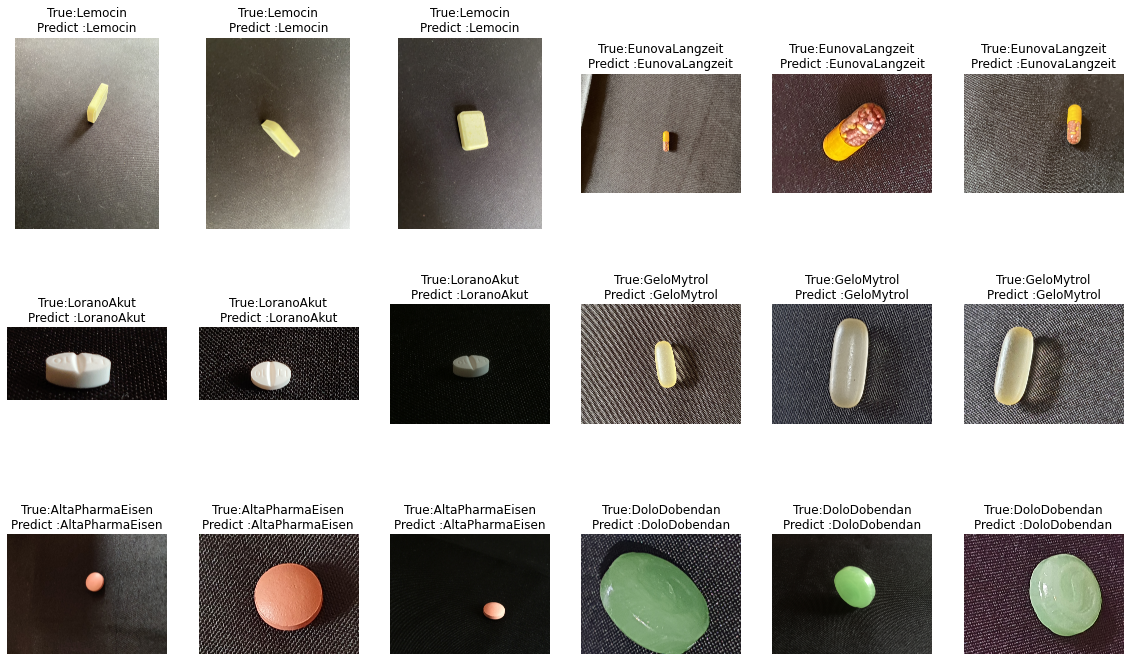

In [ ]:
show_few_images(3, model)

<IPython.core.display.Javascript object>

Saved to photo.jpg


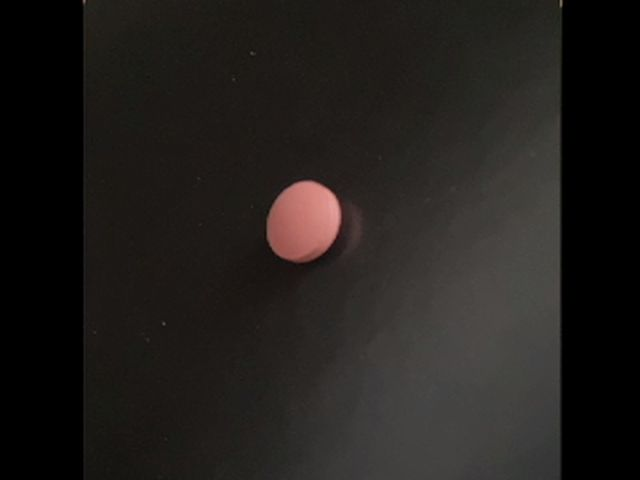

AltaPharmaEisen


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

display = plt.imread('/content/photo.jpg')
img = cv2.resize(display,(150,150))
img_normalized = img/255
predicted_classname = inv_map_classes[np.argmax(model.predict(np.array([img_normalized])))]
print(predicted_classname)